In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import re
from nltk.corpus import stopwords
nltk.download("stopwords")
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

2025-05-10 13:26:14.892196: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danedebastos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_parquet("../../data/de_poems.parquet")
df = df.astype({"title": "string", "text": "string", "author": "string", "creation": "int64"})
df.dtypes

title       string[python]
text        string[python]
author      string[python]
creation             int64
dtype: object

In [4]:
df["century"] = (df["creation"] // 100) + 1

In [5]:
german_stopwords = set(stopwords.words('german'))

def preprocess(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[\d\W_]+', ' ', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in german_stopwords]
    return ' '.join(tokens)

df['cleaned_text'] = df['text'].map(preprocess)

In [ ]:

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['cleaned_text']).toarray()
y = df['century']


X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
X_rnn = pad_sequences(sequences, maxlen=max_len)


X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_rnn, y, test_size=0.2, random_state=42)

model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(y_train_rnn.max() + 1, activation='softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(X_train_rnn, y_train_rnn,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)


test_loss, test_acc = model.evaluate(X_test_rnn, y_test_rnn)
print(f'\nPrécision sur l\'ensemble de test: {test_acc:.4f}')


/Users/danedebastos/Desktop/NLP/NLP1-Poetry/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 279s 190ms/step - accuracy: 0.5708 - loss: 1.2253 - val_accuracy: 0.7519 - val_loss: 0.7306
Epoch 2/10
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 288s 201ms/step - accuracy: 0.7910 - loss: 0.6392 - val_accuracy: 0.8059 - val_loss: 0.5819
Epoch 3/10
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 354s 223ms/step - accuracy: 0.8366 - loss: 0.5075 - val_accuracy: 0.8137 - val_loss: 0.5592
Epoch 4/10
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 280s 196ms/step - accuracy: 0.8652 - loss: 0.4156 - val_accuracy: 0.8114 - val_loss: 0.5657
Epoch 5/10
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 305s 213ms/step - accuracy: 0.8797 - loss: 0.3507 - val_accuracy: 0.8153 - val_loss: 0.5506
Epoch 6/10
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 306s 214ms/step - accuracy: 0.8982 - loss: 0.3015 - val_accuracy: 0.8086 - val_loss: 0.6135
Epoch 7/10
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 289s 202ms/step - accuracy: 0.9153 - loss: 0.2518 - val_accuracy: 0.8054 - val_loss: 0.6313
Epoch 8/10
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 303s 212ms/step - ac

448/448 ━━━━━━━━━━━━━━━━━━━━ 30s 65ms/step


<Figure size 1000x800 with 0 Axes>

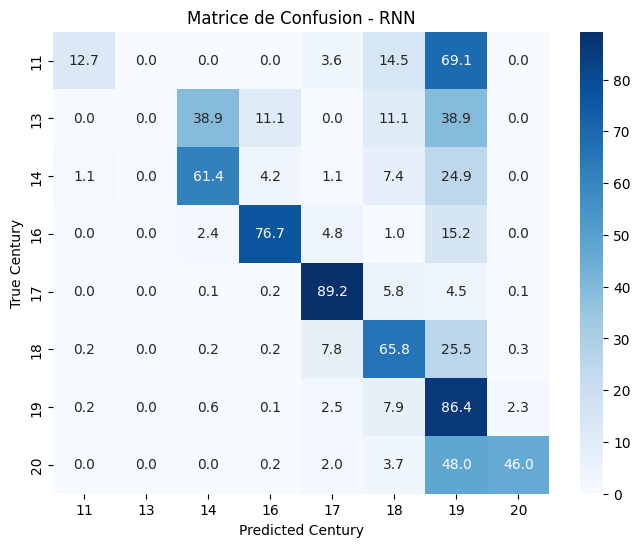


Rapport de Classification:
              precision    recall  f1-score   support

          11       0.24      0.13      0.17        55
          13       0.00      0.00      0.00        18
          14       0.66      0.61      0.64       189
          16       0.83      0.77      0.80       210
          17       0.90      0.89      0.89      4032
          18       0.71      0.66      0.68      2880
          19       0.82      0.86      0.84      6476
          20       0.56      0.46      0.51       454

    accuracy                           0.81     14314
   macro avg       0.59      0.55      0.57     14314
weighted avg       0.80      0.81      0.81     14314



/Users/danedebastos/Desktop/NLP/NLP1-Poetry/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danedebastos/Desktop/NLP/NLP1-Poetry/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danedebastos/Desktop/NLP/NLP1-Poetry/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [7]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test_rnn)
y_pred_classes = np.argmax(y_pred, axis=1)

# Création de la matrice de confusion en pourcentage
plt.figure(figsize=(10, 8))
cm_tfidf = confusion_matrix(y_test_rnn, y_pred_classes)  # Utilisation de y_test_rnn et y_pred_classes
cm_tfidf_percent = cm_tfidf.astype('float') / cm_tfidf.sum(axis=1)[:, np.newaxis] * 100

centuries = sorted(np.unique(np.concatenate((y_test_rnn, y_pred_classes))))

plt.figure(figsize=(8,6))
sns.heatmap(cm_tfidf_percent, annot=True, fmt=".1f", cmap='Blues', xticklabels=centuries, yticklabels=centuries)
plt.xlabel('Predicted Century')
plt.ylabel('True Century')
plt.title('Matrice de Confusion - RNN')
plt.show()

# Affichage du rapport de classification
print("\nRapport de Classification:")
print(classification_report(y_test_rnn, y_pred_classes))


In [8]:
report = classification_report(y_test_rnn, y_pred_classes, output_dict=True)

accurency_tfidf = report['accuracy']

precision_tfidf = report['weighted avg']['precision']

recall_tfidf = report['weighted avg']['recall']

f1_score_tfidf = report['weighted avg']['f1-score']

print(accurency_tfidf,precision_tfidf,recall_tfidf,f1_score_tfidf)

0.8089283219225932 0.8038648754492868 0.8089283219225932 0.8056610547103551


/Users/danedebastos/Desktop/NLP/NLP1-Poetry/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danedebastos/Desktop/NLP/NLP1-Poetry/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danedebastos/Desktop/NLP/NLP1-Poetry/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [9]:
# Calcul de l'AUC-ROC
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binariser les labels pour la classification multi-classes
classes = np.unique(y_test_rnn)
y_test_bin = label_binarize(y_test_rnn, classes=classes)

# S'assurer que les dimensions correspondent
y_score = model.predict(X_test_rnn)
if y_score.shape[1] != len(classes):
    y_score = y_score[:, :len(classes)]

# Calcul de l'AUC moyenne
roc_auc = roc_auc_score(y_test_bin, y_score, multi_class='ovr')
print(f"\nAUC moyenne: {roc_auc:.3f}")




448/448 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step

AUC moyenne: 0.626


In [10]:
benchmark = pd.read_parquet("../../class_bench.parquet")
display(benchmark)

Accuracy  Avg Precision  \
Encoding Model                                                            
TF-IDF   Bagging - Logistic Regression          0.515859       0.728819   
         Feedforward Neural Network             0.870896       0.869331   
         Logistic Regression                    0.851125       0.850301   
         Naive Bayes                            0.737390       0.791740   
         Random Forest                          0.776513       0.776507   
         Recurrent Neural Network               0.000000       0.000000   
         Stacking - Random Forest / KNeighbors  0.820246       0.819690   
Word2Vec Feedforward Neural Network             0.000000       0.000000   
         Logistic Regression                    0.784547       0.816938   
         Multi-Layer Perceptron                 0.840506       0.837564   
         Naive Bayes                            0.000000       0.000000   
         Random Forest                          0.814028       0.809732   
         Recurrent Neural Network               0.717968       0.793872   

                                                Avg Recall  Avg F1-Score  \
Encoding Model                                                             
TF-IDF   Bagging - Logistic Regression            0.515859      0.569268   
         Feedforward Neural Network               0.870896      0.868993   
         Logistic Regression                      0.851125      0.850428   
         Naive Bayes                              0.737390      0.756293   
         Random Forest                            0.776513      0.759780   
         Recurrent Neural Network                 0.000000      0.000000   
         Stacking - Random Forest / KNeighbors    0.820246      0.808860   
Word2Vec Feedforward Neural Network               0.000000      0.000000   
         Logistic Regression                      0.784547      0.794427   
         Multi-Layer Perceptron                   0.840506      0.838563   
         Naive Bayes                              0.000000      0.000000   
         Random Forest                            0.814028      0.809036   
         Recurrent Neural Network                 0.717968      0.730375   

                                                 Avg AUC  \
Encoding Model                                             
TF-IDF   Bagging - Logistic Regression          0.890785   
         Feedforward Neural Network             0.980472   
         Logistic Regression                    0.976420   
         Naive Bayes                            0.932115   
         Random Forest                          0.927325   
         Recurrent Neural Network               0.000000   
         Stacking - Random Forest / KNeighbors  0.962778   
Word2Vec Feedforward Neural Network             0.000000   
         Logistic Regression                    0.959170   
         Multi-Layer Perceptron                 0.983007   
         Naive Bayes                            0.000000   
         Random Forest                          0.946552   
         Recurrent Neural Network               0.965358   

                                                Avg Training time (m)  
Encoding Model                                                         
TF-IDF   Bagging - Logistic Regression                           0.50  
         Feedforward Neural Network                              0.00  
         Logistic Regression                                     0.00  
         Naive Bayes                                             0.17  
         Random Forest                                           0.00  
         Recurrent Neural Network                                0.00  
         Stacking - Random Forest / KNeighbors                  20.00  
Word2Vec Feedforward Neural Network                              0.00  
         Logistic Regression                                     0.00  
         Multi-Layer Perceptron                                  0.00  
         Naive B

In [11]:

benchmark.loc[
    ("TF-IDF", "Recurrent Neural Network"),
    ["Avg Recall", "Avg F1-Score", "Avg Precision", "Accuracy", "Avg AUC"],
] = [recall_tfidf, f1_score_tfidf, precision_tfidf, accurency_tfidf, roc_auc]

benchmark.to_parquet("../../class_bench.parquet", index=True)

display(benchmark)

Accuracy  Avg Precision  \
Encoding Model                                                            
TF-IDF   Bagging - Logistic Regression          0.515859       0.728819   
         Feedforward Neural Network             0.870896       0.869331   
         Logistic Regression                    0.851125       0.850301   
         Naive Bayes                            0.737390       0.791740   
         Random Forest                          0.776513       0.776507   
         Recurrent Neural Network               0.808928       0.803865   
         Stacking - Random Forest / KNeighbors  0.820246       0.819690   
Word2Vec Feedforward Neural Network             0.000000       0.000000   
         Logistic Regression                    0.784547       0.816938   
         Multi-Layer Perceptron                 0.840506       0.837564   
         Naive Bayes                            0.000000       0.000000   
         Random Forest                          0.814028       0.809732   
         Recurrent Neural Network               0.717968       0.793872   

                                                Avg Recall  Avg F1-Score  \
Encoding Model                                                             
TF-IDF   Bagging - Logistic Regression            0.515859      0.569268   
         Feedforward Neural Network               0.870896      0.868993   
         Logistic Regression                      0.851125      0.850428   
         Naive Bayes                              0.737390      0.756293   
         Random Forest                            0.776513      0.759780   
         Recurrent Neural Network                 0.808928      0.805661   
         Stacking - Random Forest / KNeighbors    0.820246      0.808860   
Word2Vec Feedforward Neural Network               0.000000      0.000000   
         Logistic Regression                      0.784547      0.794427   
         Multi-Layer Perceptron                   0.840506      0.838563   
         Naive Bayes                              0.000000      0.000000   
         Random Forest                            0.814028      0.809036   
         Recurrent Neural Network                 0.717968      0.730375   

                                                 Avg AUC  \
Encoding Model                                             
TF-IDF   Bagging - Logistic Regression          0.890785   
         Feedforward Neural Network             0.980472   
         Logistic Regression                    0.976420   
         Naive Bayes                            0.932115   
         Random Forest                          0.927325   
         Recurrent Neural Network               0.625668   
         Stacking - Random Forest / KNeighbors  0.962778   
Word2Vec Feedforward Neural Network             0.000000   
         Logistic Regression                    0.959170   
         Multi-Layer Perceptron                 0.983007   
         Naive Bayes                            0.000000   
         Random Forest                          0.946552   
         Recurrent Neural Network               0.965358   

                                                Avg Training time (m)  
Encoding Model                                                         
TF-IDF   Bagging - Logistic Regression                           0.50  
         Feedforward Neural Network                              0.00  
         Logistic Regression                                     0.00  
         Naive Bayes                                             0.17  
         Random Forest                                           0.00  
         Recurrent Neural Network                                0.00  
         Stacking - Random Forest / KNeighbors                  20.00  
Word2Vec Feedforward Neural Network                              0.00  
         Logistic Regression                                     0.00  
         Multi-Layer Perceptron                                  0.00  
         Naive B